<a href="https://colab.research.google.com/github/winac/FYP/blob/master/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Downloading the data
!rm -rf FYP
!git clone https://github.com/winac/FYP.git

Cloning into 'FYP'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 70 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [0]:
#Import Statements
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import networkx as nx
import pandas_datareader as web
import datetime as dt
import seaborn as sns
import math

!pip install investpy
import investpy

import warnings
warnings.filterwarnings("ignore")

# Gold Price

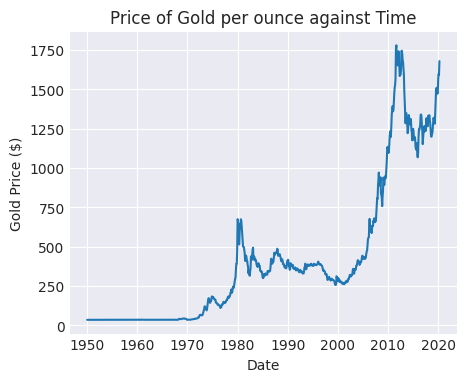

In [0]:
#Read Data
df = pd.read_csv("FYP/gold.csv")

#Transform Data
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

#Plot Data
fig = plt.figure(dpi=100, figsize=(5,4))
with plt.style.context('seaborn-darkgrid'):
  plt.plot(df.index, df["Price"])
  plt.title('Price of Gold per ounce against Time')
  plt.xlabel('Date')
  plt.ylabel('Gold Price ($)')
plt.show()

fig.savefig('Gold.pdf')

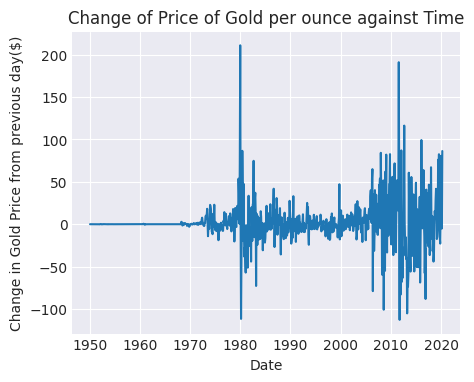

In [0]:
#Transform Data
df = df.diff()[1:]

#Plot Data
fig = plt.figure(dpi=100, figsize=(5,4))
with plt.style.context('seaborn-darkgrid'):
  plt.plot(df.index, df["Price"])
  plt.title('Change of Price of Gold per ounce against Time')
  plt.xlabel('Date')
  plt.ylabel('Change in Gold Price from previous day($)')
plt.show()

fig.savefig('Gold-difference.pdf')

# Helper Functions

In [0]:
#Plot the Data
def plot_data(df):
  with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, dpi=120, figsize=(10,len(df.columns)*2))
    for i, ax in enumerate(axes.flatten()):
      data = df[df.columns[i]]
      ax.plot(data, color='red', linewidth=1)
      ax.set_title(df.columns[i])
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
      plt.tight_layout()
  plt.show()
  fig.savefig('plot.pdf')

In [0]:
#https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6
def adfullertest(series, signif=0.05, name='', verbose=False): 
  """Perform ADFuller to test for Stationarity of given series and print report""" 
  r = adfuller(series, autolag='AIC') 
  output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]} 
  p_value = output['pvalue'] 
  def adjust(val, length= 6): return str(val).ljust(length) 
  # Print Summary 
  print(f' Augmented Dickey-Fuller Test on "{name}"' , "\n ", '-'*47) 
  print(f' Null Hypothesis: Data has unit root. Non-Stationary.') 
  print(f' Significance Level = {signif}') 
  print(f' Test Statistic = {output["test_statistic"]}') 
  print(f' No. Lags Chosen = {output["n_lags"]}') 
  for key,val in r[4].items():
    print(f' Critical value {adjust(key)} = {round(val, 3)}') 
  if p_value <= signif: 
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.") 
    print(f" => Series is Stationary.") 
  else: 
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.") 
    print(f" => Series is Non-Stationary.") 

def adfuller_test(df, significance = 0.05):
  for c in df.columns:
    adfullertest(df[c], signif=significance, name=c)
    print()

In [0]:
def correlation_network(matrix, signif=0.3):
  links = matrix.stack().reset_index()
  links.columns = ['var1', 'var2','value']
  
  # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
  links_filtered = links.loc[(np.abs(links['value']) > signif) & (links['var1'] != links['var2'])]

  # Build your graph
  G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr=True)
  
  # Plot the network:
  nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

  #Scale Figure
  l,r = plt.xlim()
  plt.xlim(l-2,r+2)
  plt.savefig('correlation.pdf')

In [0]:
#https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6
def grangers_causation_matrix(data, variables, maxlag, test='ssr_chi2test', verbose=False): 
  X_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables) 
  for c in X_train.columns: 
    for r in X_train.index: 
      test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)] 
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_valuesy}') 
      min_p_value = np.min(p_values) 
      X_train.loc[r, c] = min_p_value #need to get lag
  X_train.columns = [var for var in variables] 
  X_train.index = [var for var in variables] 
  return X_train 

In [0]:
def get_labels_causation(granger_matrix, maxlag):
  labels = {}
  for i in range(len(granger_matrix.index)):
    for j in range(len(granger_matrix.columns)):
      if i == j:
        continue
      else:
        if granger_matrix.iloc[i, j] < 0.05:
          tmp = transform_data[[granger_matrix.index[i], granger_matrix.columns[j]]]
          test_result = grangercausalitytests(tmp, maxlag=maxlag, verbose=False)
          p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]
          chi_stats = [round(test_result[i+1][0]['ssr_chi2test'][0],4) for i in range(maxlag)]
          res = [ n for n,i in enumerate(p_values) if i<0.05 ]
          chi_stats = [chi_stats[i] for i in res]
          lag_value = res[chi_stats.index(min(chi_stats))]+1
          labels[(granger_matrix.columns[j],granger_matrix.index[i])] = lag_value
          print(f'{granger_matrix.columns[j]} causes {granger_matrix.index[i]}, with chi-stat of {round(test_result[lag_value][0]["ssr_chi2test"][0])} and for it p-value of {round(test_result[lag_value][0]["ssr_chi2test"][1], 2)} and lag of {lag_value}')
  return labels

In [0]:
def granger_network(matrix, signif=0.05, labels=None):
  links = matrix.stack().reset_index()
  links.columns = ['var1', 'var2','value']
  
  # Keep only correlation over a threshold and remove self causation
  links_filtered = links.loc[(links['value'] < signif) & (links['value'] != 1) ]

  # Build your graph
  G = nx.from_pandas_edgelist(links_filtered, 'var2', 'var1', edge_attr=True, create_using=nx.MultiDiGraph)

  pos = nx.spring_layout(G)
  
  # Plot the network:
  nx.draw(G, pos, arrows=True, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)
  
  #Add labels
  if(labels != None):
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.3)

  #Scale Figure
  l,r = plt.xlim()
  plt.xlim(l-2,r+2)
  plt.savefig('causality.pdf')

In [0]:
def rolling_correlation(x, y, x_name, y_name, window_size):
  res = y.rolling(window_size).corr(x)
  fig = plt.figure()
  with plt.style.context('seaborn-darkgrid'):
    plt.xticks(rotation=45)
    plt.title(f"{x_name} and {y_name}")
    plt.ylabel("Correlation Coefficient")
    plt.xlabel("Date")
    plt.plot(res)
    plt.tight_layout()
  plt.show()
  fig.savefig('correl.pdf')

In [0]:
def rolling_causality(x, y, x_name, y_name, window_size):
  rolling_y = y.rolling(window_size)
  rolling_x = x.rolling(window_size)
  
  rolling_y_saved = []
  rolling_x_saved = []

  def save(data, name):
      if name == "Y":
        rolling_y_saved.append(data)
      else:
        rolling_x_saved.append(data)
      return data.sum()

  rolling_x.apply(save, args=("X",)).dropna()
  rolling_y.apply(save, args=("Y",)).dropna()

  res = pd.DataFrame()
  res["rolling_x"] = rolling_x_saved
  res["rolling_y"] = rolling_y_saved

  def func(x, y):
    res = pd.DataFrame()
    res["rolling_x"] = x
    res["rolling_y"] = y
    maxlag = min(math.floor((res[["rolling_y", "rolling_x"]].shape[0])/3)-1, 90) #The maximum allowable maxlag is 90 (90 days)
    
    test_result = grangercausalitytests(res[["rolling_y", "rolling_x"]], maxlag=maxlag, verbose=False)
    p_values = [test_result[i+1][0]["ssr_ftest"][1] for i in range(maxlag)]
    return 0 if min(p_values)<0.05 else 1
  grangers = list(map(lambda x, y: func(x, y), res["rolling_y"], res["rolling_x"]))
  
  fig = plt.figure()
  with plt.style.context('seaborn-darkgrid'):
    plt.xticks(rotation=45)
    plt.title(f"{x_name} causes {y_name}")
    plt.xlabel("Date")
    plt.yticks(np.arange(2), ('Causal', 'Not Causal'))
    plt.plot(y.index.tolist()[window_size-1:], grangers)
    plt.tight_layout()
  plt.show()
  fig.savefig('causal.pdf')

# Ice Cream Sales cause Drownings

In [0]:
#Import Data
df = pd.read_csv("FYP/real-case.csv")
#Format Data
df.set_index('Month',inplace=True)

In [0]:
df

,Sales,Drownings,Temperature
Month,,,
January,83.4343,177,32.16
February,99.4899,162,35.51
March,107.3152,212,42.73
April,112.4309,247,49.03
May,110.3544,390,65.52
June,124.5841,543,71.55
July,117.2215,667,75.45
August,112.6779,463,73.51
September,103.3118,305,67.53


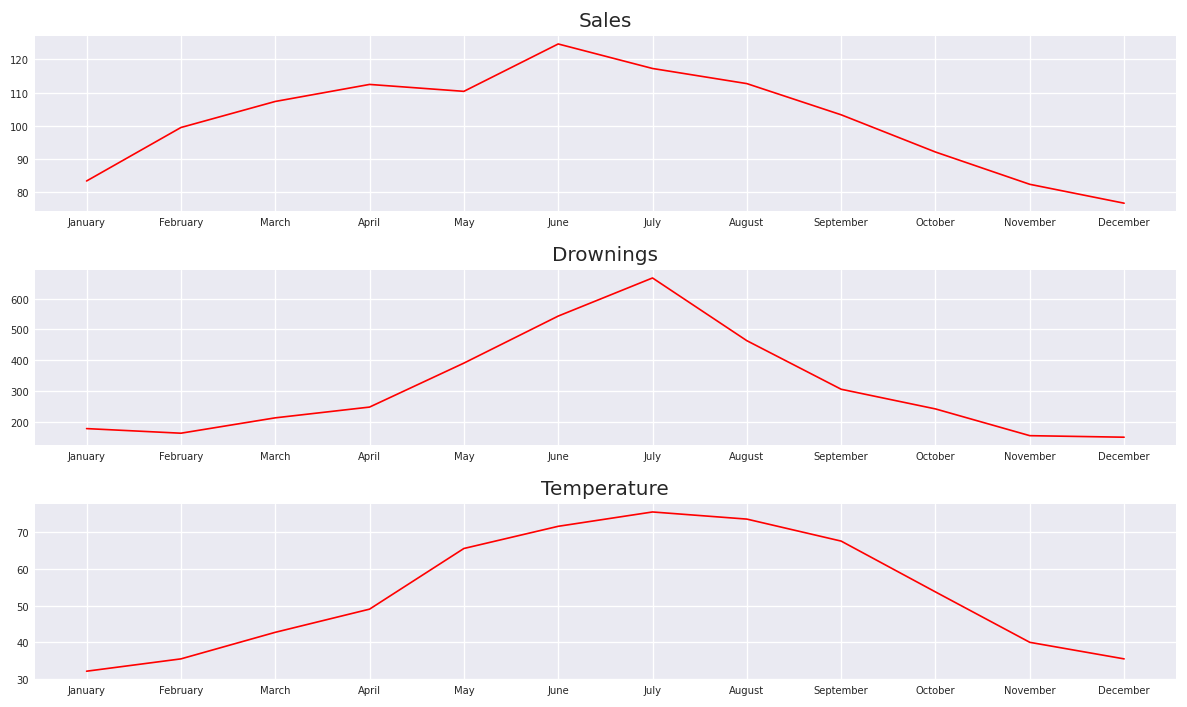

In [0]:
plot_data(df)

In [0]:
#Transformation
transform_data = df.diff().diff().diff().dropna()

In [0]:
adfuller_test(transform_data)

 Augmented Dickey-Fuller Test on "Sales" 
  -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -3.2839
 No. Lags Chosen = 1
 Critical value 1%     = -4.939
 Critical value 5%     = -3.478
 Critical value 10%    = -2.844
 => P-Value = 0.0156. Rejecting Null Hypothesis.
 => Series is Stationary.

 Augmented Dickey-Fuller Test on "Drownings" 
  -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -3.8093
 No. Lags Chosen = 0
 Critical value 1%     = -4.665
 Critical value 5%     = -3.367
 Critical value 10%    = -2.803
 => P-Value = 0.0028. Rejecting Null Hypothesis.
 => Series is Stationary.

 Augmented Dickey-Fuller Test on "Temperature" 
  -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -4.7717
 No. La

In [0]:
correlation_matrix = transform_data.corr(method ='pearson')
correlation_matrix = correlation_matrix.round(2)
correlation_matrix

,Sales,Drownings,Temperature
Sales,1.00,-0.43,-0.64
Drownings,-0.43,1.00,0.33
Temperature,-0.64,0.33,1.00


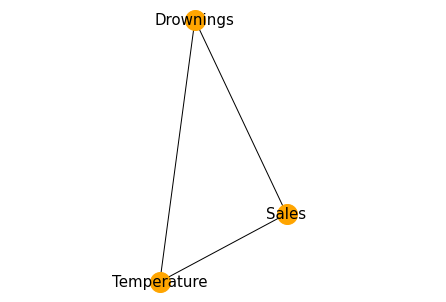

In [0]:
correlation_network(correlation_matrix, signif=0.3)

In [0]:
granger_matrix = grangers_causation_matrix(transform_data, variables = transform_data.columns, maxlag=2) 
granger_matrix = granger_matrix.round(2)
granger_matrix

,Sales,Drownings,Temperature
Sales,1.00,0.17,0.0
Drownings,0.00,1.00,0.0
Temperature,0.45,0.27,1.0


In [0]:
labels = get_labels_causation(granger_matrix, maxlag=2)

Temperature causes Sales, with chi-stat of 29.0 and for it p-value of 0.0 and lag of 1
Sales causes Drownings, with chi-stat of 7.0 and for it p-value of 0.01 and lag of 1
Temperature causes Drownings, with chi-stat of 29.0 and for it p-value of 0.0 and lag of 2


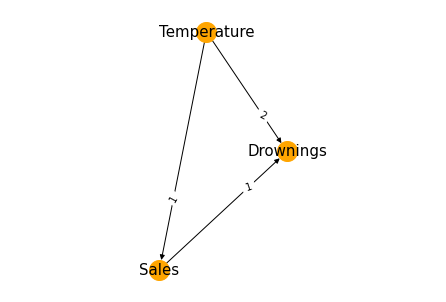

In [0]:
granger_network(granger_matrix, labels=labels)

# Stocks

Stocks chosen are UPS, American Airlines and Hyatt.

In [0]:
tickers = ["UPS", "AAL", "H"]
mapping_dict =	{
  "UPS": "UPS",
  "AAL": "American Airlines",
  "H": "Hyatt"
}

In [0]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2020, 1, 1)
df = pd.DataFrame()
for ticker in tickers:
  df[mapping_dict[ticker]] = web.DataReader(ticker, 'yahoo', start, end)['Close'] #Get closing price
df.isnull().values.any()

False

In [0]:
df

,UPS,American Airlines,Hyatt
Date,,,
2010-01-04,58.180000,4.770000,29.959999
2010-01-05,58.279999,5.310000,30.000000
2010-01-06,57.849998,5.090000,29.719999
2010-01-07,57.410000,5.240000,29.889999
2010-01-08,60.169998,5.140000,29.709999
...,...,...,...
2019-12-24,118.330002,29.180000,89.739998
2019-12-26,119.040001,29.670000,90.699997
2019-12-27,118.940002,28.440001,90.680000


In [0]:
df.to_csv("financial-data.csv")

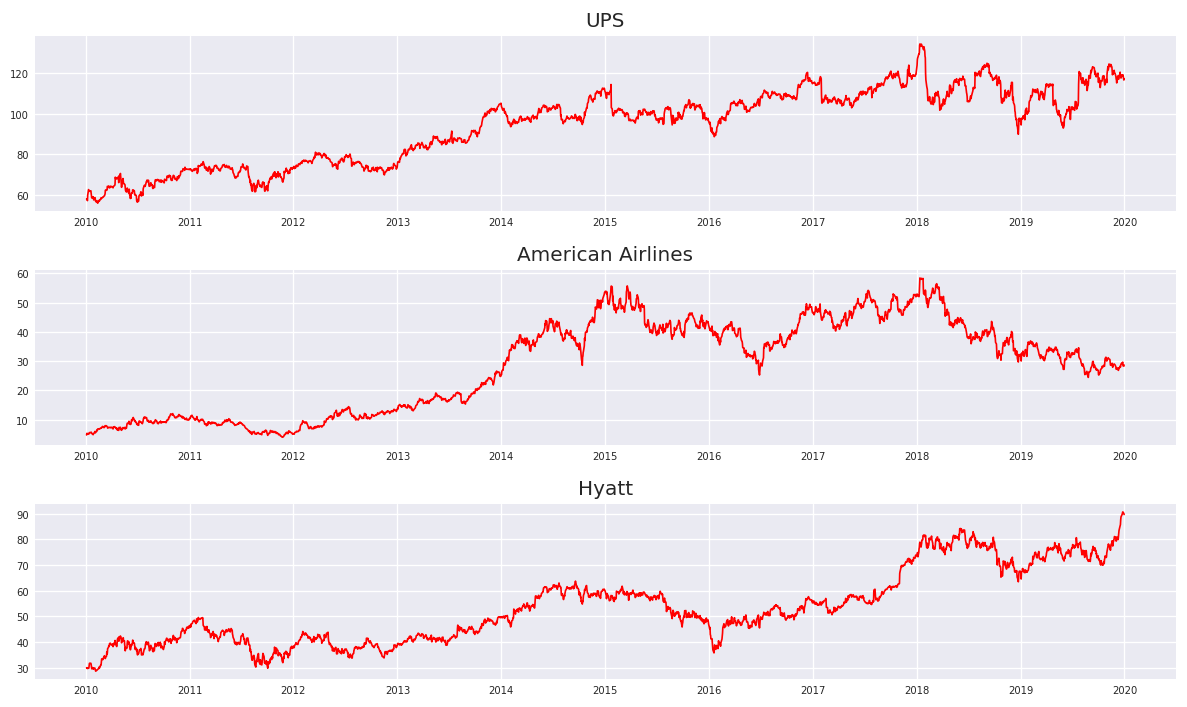

In [0]:
plot_data(df)

In [0]:
#Transformation
transform_data = df.diff().dropna()

In [0]:
adfuller_test(transform_data)

 Augmented Dickey-Fuller Test on "UPS" 
  -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -48.9037
 No. Lags Chosen = 0
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

 Augmented Dickey-Fuller Test on "American Airlines" 
  -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -47.7495
 No. Lags Chosen = 0
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

 Augmented Dickey-Fuller Test on "Hyatt" 
  -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -49.9304
 No. Lags 

In [0]:
correlation_matrix = transform_data.corr(method ='pearson')
correlation_matrix = correlation_matrix.round(2)
correlation_matrix

,UPS,American Airlines,Hyatt
UPS,1.00,0.35,0.41
American Airlines,0.35,1.00,0.35
Hyatt,0.41,0.35,1.00


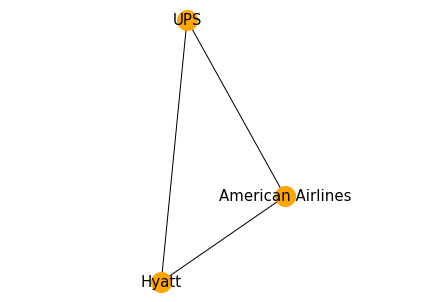

In [0]:
correlation_network(correlation_matrix, signif=0.3)

In [0]:
granger_matrix = grangers_causation_matrix(transform_data, variables = transform_data.columns, maxlag=90)
granger_matrix = granger_matrix.round(2)
granger_matrix

,UPS,American Airlines,Hyatt
UPS,1.00,0.00,0.08
American Airlines,0.15,1.00,0.33
Hyatt,0.02,0.01,1.00


In [0]:
labels = get_labels_causation(granger_matrix, maxlag=90)

American Airlines causes UPS, with chi-stat of 69.0 and for it p-value of 0.04 and lag of 50
UPS causes Hyatt, with chi-stat of 4.0 and for it p-value of 0.04 and lag of 1
American Airlines causes Hyatt, with chi-stat of 7.0 and for it p-value of 0.03 and lag of 2


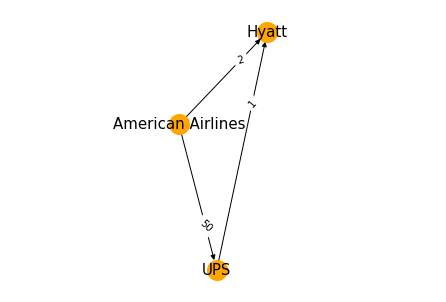

In [0]:
granger_network(granger_matrix, signif=0.05, labels=labels)

# Bicausality and Rolling Window

In [0]:
tickers = ["AIR.PA", "BA"]
mapping_dict =	{
  "AIR.PA": "Airbus",
  "BA": "Boeing"
}

In [0]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2020, 1, 1)
df = pd.DataFrame()
for ticker in tickers:
  df[mapping_dict[ticker]] = web.DataReader(ticker, 'yahoo', start, end)['Close'] #Get closing price
df.isnull().values.any()

True

In [0]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN

,Airbus,Boeing
Date,,
2010-01-18,14.710000,NaN
2010-02-15,13.550000,NaN
2010-05-31,16.290001,NaN
2010-07-05,16.174999,NaN
2010-09-06,18.059999,NaN
...,...,...
2019-05-27,116.839996,NaN
2019-07-04,125.379997,NaN
2019-09-02,126.000000,NaN


In [0]:
df.interpolate(methods="linear", inplace=True)

In [0]:
df

,Airbus,Boeing
Date,,
2010-01-04,13.990000,56.180000
2010-01-05,13.945000,58.020000
2010-01-06,14.070000,59.779999
2010-01-07,14.210000,62.200001
2010-01-08,14.350000,61.599998
...,...,...
2019-12-24,133.139999,333.000000
2019-12-25,133.139999,331.570007
2019-12-27,133.279999,330.140015


In [0]:
df.to_csv("financial-data-bicausal.csv")

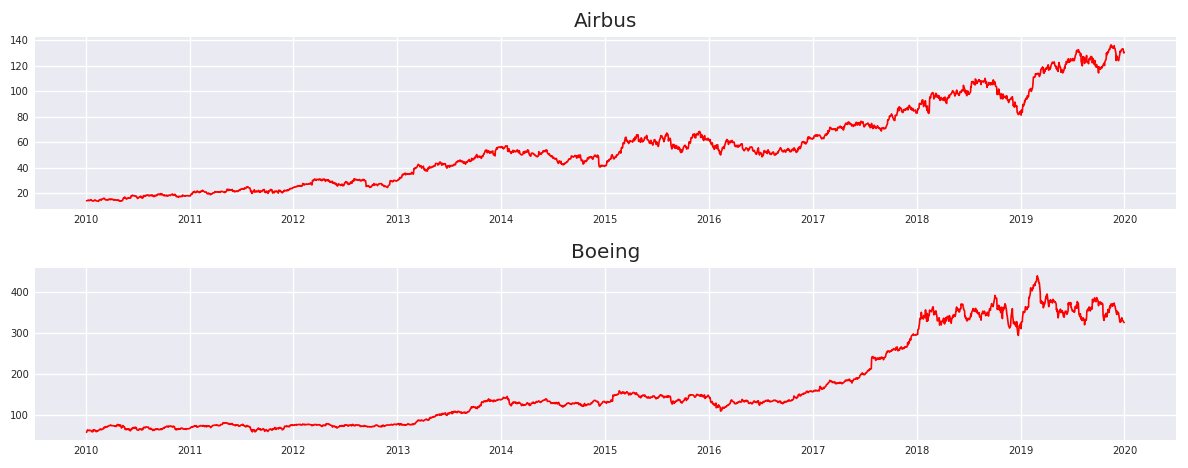

In [0]:
plot_data(df)

In [0]:
transform_data = df.diff().dropna()

In [0]:
adfuller_test(transform_data)

 Augmented Dickey-Fuller Test on "Airbus" 
  -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -37.567
 No. Lags Chosen = 1
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

 Augmented Dickey-Fuller Test on "Boeing" 
  -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -9.9158
 No. Lags Chosen = 22
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



In [0]:
correlation_matrix = transform_data.corr(method ='pearson')
correlation_matrix = correlation_matrix.round(2)
correlation_matrix

,Airbus,Boeing
Airbus,1.00,0.27
Boeing,0.27,1.00


In [0]:
granger_matrix = grangers_causation_matrix(transform_data, variables = transform_data.columns, maxlag=90)
granger_matrix = granger_matrix.round(2)
granger_matrix

,Airbus,Boeing
Airbus,1.0,0.0
Boeing,0.0,1.0


In [0]:
labels = get_labels_causation(granger_matrix, maxlag=90)

Boeing causes Airbus, with chi-stat of 8.0 and for it p-value of 0.05 and lag of 3
Airbus causes Boeing, with chi-stat of 18.0 and for it p-value of 0.01 and lag of 7


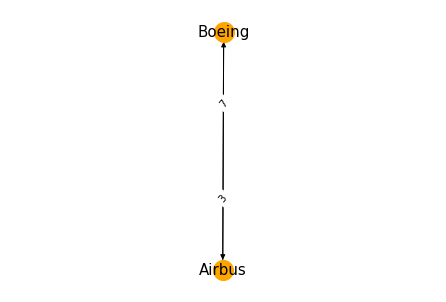

In [0]:
granger_network(granger_matrix, signif=0.05, labels=labels)

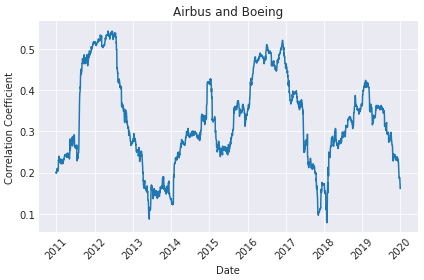

In [0]:
rolling_correlation(transform_data["Airbus"], transform_data["Boeing"], "Airbus", "Boeing", 252)

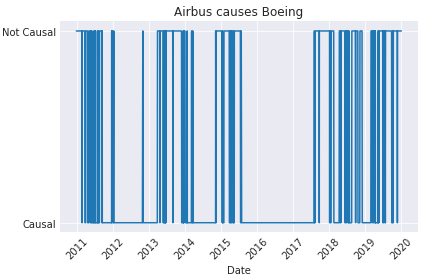

In [0]:
rolling_causality(transform_data["Airbus"], transform_data["Boeing"], "Airbus", "Boeing", 252)

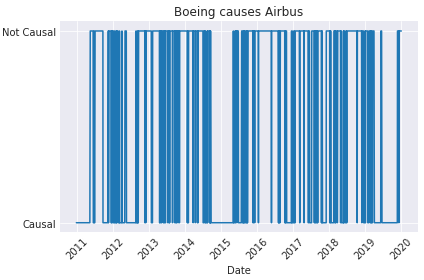

In [0]:
rolling_causality(transform_data["Boeing"], transform_data["Airbus"], "Boeing", "Airbus", 252)